In [30]:
%load_ext autoreload
%autoreload 2

import os
import sys

module_path = os.path.abspath("RS/thinker/thinker")
if module_path not in sys.path:
    sys.path.append(module_path)

from collections import namedtuple
from matplotlib import pyplot as plt
import matplotlib.ticker as mticker
from collections import deque
import time
import numpy as np
import argparse
import torch
import torch.nn.functional as F
from thinker.env import Environment
from thinker.net import ActorNet, ModelNet
from thinker.buffer import ModelBuffer
import thinker.util as util

def plot_gym_env_out(x, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    ax.imshow(
        torch.swapaxes(torch.swapaxes(x[0].cpu(), 0, 2), 0, 1),
        interpolation="nearest",
        aspect="auto",
    )
    if title is not None:
        ax.set_title(title)

def compute_target_v(r, bs_v, gamma, done=None):
    """
    params:
        bs_v: bootstrap value v_{T}; tensor of shape [B, N] 
        r: reward; tensor of shape [T, B, N] r_0, r_1, ..., r_{T-1}
        gamma: scalar; discount rate
        done: bool; tensor of shape [T, B] d_0, d_1, ..., d_{T-1}
    output:
        target_v: target value; tensor of shape [T, B, N]
    (same as vtrace but without importance sampling)
    """
    T, B, N = r.shape
    target_v = torch.zeros_like(r)       
    if done is not None:
        done = (~done).float()
    else:
        done = torch.ones(T, B, device=r.device)
    if bs_v is None:
        bs_v = torch.zeros(B, N, device=r.device)
    target_v[-1] = r[-1] + gamma * done[-1].unsqueeze(-1) * bs_v    
    for t in reversed(range(T-1)):
        target_v[t] = r[t] + gamma * done[t].unsqueeze(-1) * target_v[t+1]        
    target_v = torch.concat([target_v, bs_v.unsqueeze(0)], dim=0)
    return target_v   

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
checkpoint = False
args = '--emotion_type 1 --disable_model --sep_aux 1'
check_point_path = '/home/schk/logs/v1h_sigmoid'

if checkpoint:
    flags = util.parse(['--load_checkpoint', check_point_path])
else:
    flags = util.parse(args.split(" "))
    
device = torch.device("cpu")
env = Environment(flags=flags, model_wrap=False, env_n=2, device=device)
actor_net = ActorNet(obs_shape=None, gym_obs_shape=(12,96,96), num_actions=env.num_actions, flags=flags)
if checkpoint:
    train_checkpoint = torch.load(os.path.join(check_point_path, "ckp_actor.tar"), torch.device("cpu"))
    actor_net.set_weights(train_checkpoint["actor_net_state_dict"])
actor_net.train(False)
obs = env.initial()

Automatically setting rec_t = 1 (disable model).
Automatically disable training model (disable model).
Automatically setting im_cost = 0 (disable model).
Automatically setting actor_see_type = 0 (disable model).


A.L.E: Arcade Learning Environment (version 0.7.5+db37282)
[Powered by Stella]


In [59]:
# emotion branch 
import subprocess

run = "v1l_bp_2e-4reg_simple"
refresh = False

check_point_path = "/home/schk/logs/" + run
if refresh or not os.path.exists(check_point_path):
    script_path = "down_wandb.py"
    subprocess.run(["python", script_path, "--run", run, "--output_path", "/home/schk/logs"])

#check_point_path = "/home/schk/logs/v1i_base_sep3"
device = torch.device("cpu")

flags = util.parse(['--load_checkpoint', check_point_path])
env = Environment(flags=flags, model_wrap=False, env_n=2, device=device)
actor_net = ActorNet(obs_shape=None, gym_obs_shape=(12,96,96), num_actions=env.num_actions, flags=flags)
train_checkpoint = torch.load(os.path.join(check_point_path, "ckp_actor.tar"), torch.device("cpu"))
actor_net.set_weights(train_checkpoint["actor_net_state_dict"])
actor_net.train(False)
#actor_net.refresh_aux_reward(checkpoint_path="/home/schk/log/v1i_base_sep3")
obs = env.initial()

aux_vs, aux_rs, encs, logits = [], [], [], []
for n in range(100):

    actor_out, core_state = actor_net(obs)
    if actor_net.emotion_type == 1:
        aux_v = actor_out.baseline[0, :, actor_net.num_rewards:]
    aux_vs.append(aux_v)    
    logits.append(actor_out.policy_logits)
    obs = env.step(actor_out.action.unsqueeze(-1))

    model_enc = obs.gym_env_out.float() / 255.0
    model_enc = torch.flatten(model_enc, 0, 1)
    enc, _ = actor_net.actor_encoder(model_enc)
    encs.append(enc)
    if actor_net.emotion_type == 1:
        aux_reward = actor_net.compute_aux_reward(obs)
        aux_rs.append(aux_reward[0])    
    if n % 10 == 0: print("Step %d." % n)
aux_rs = torch.stack(aux_rs, dim=0)    
aux_vs = torch.stack(aux_vs, dim=0)    

Step 0.
Step 10.
Step 20.
Step 30.
Step 40.
Step 50.
Step 60.
Step 70.
Step 80.
Step 90.


L2 loss: tensor(17.1475, grad_fn=<MulBackward0>)


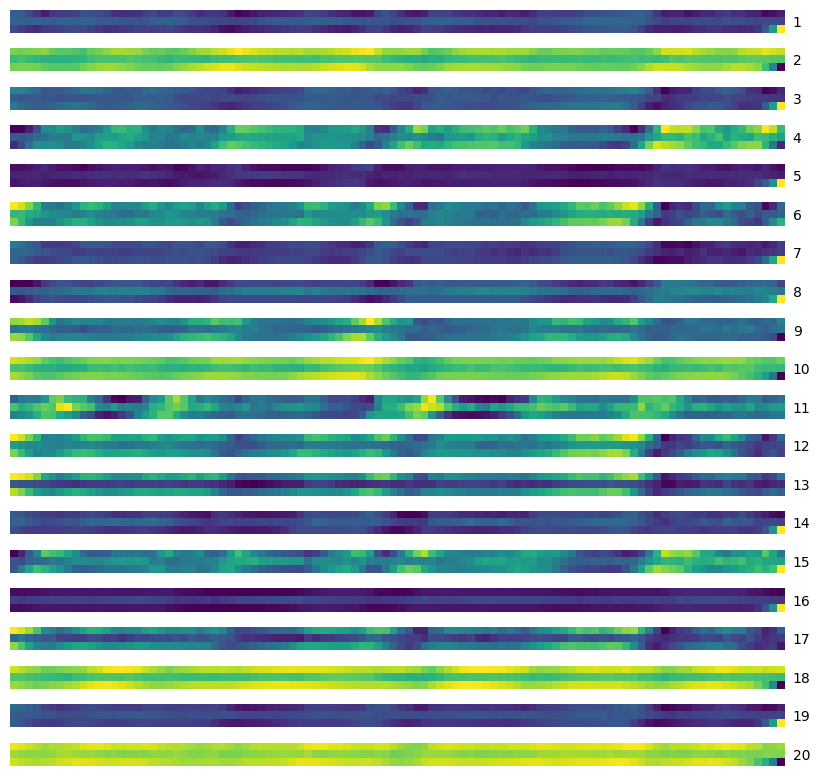

In [60]:
d = 2
discount = flags.aux_discounting[d]

T, B, N = aux_rs.shape
ars = actor_net.num_aux_rewards
r = aux_rs[:,0].detach().numpy().T
v = aux_vs[:,0,d*ars:(d+1)*ars].detach().numpy().T
target_v = compute_target_v(aux_rs, aux_vs[-1,:,d*ars:(d+1)*ars], gamma=discount)[1:] * (1 - discount)
target_v_ = target_v[:,0].detach().numpy().T
l2_loss = torch.sum((target_v - aux_vs[:,:,d*ars:(d+1)*ars])**2)
print("L2 loss:", l2_loss / T / B * 20 * 16)

ys = []
for i in range(N):
    y = np.zeros((3, T))
    y[0] = r[i]
    y[1] = v[i] 
    y[2] = target_v_[i] 
    ys.append(y)
ys = ys[:20]

fig = plt.figure(figsize=(10, 0.5 * len(ys)))  # adjust the size as needed
# Create each subplot
for i, y in enumerate(ys, start=1):
    ax = fig.add_subplot(len(ys), 1, i)
    img = ax.imshow(y)  # 'auto' to adjust aspect ratio as per the input arrays
    ax.axis('off')  # turn off axes
    ax.text(1.01, 0.45, str(i), va='center', ha='left', transform=ax.transAxes) # Add the index on the right side of each subplot, vertically centered

plt.subplots_adjust(wspace=0, hspace=0.05)  # adjust the space between subplots if needed
plt.show()

# first row is reward
# second row is predict value
# third row is target value

In [57]:
aux_rs[:,0,7]

tensor([1.4156e-18, 1.4050e-18, 1.3959e-18, 1.3886e-18, 1.3921e-18, 1.4124e-18,
        1.4304e-18, 1.4504e-18, 1.4777e-18, 1.4764e-18, 1.5064e-18, 1.5158e-18,
        1.5333e-18, 1.5478e-18, 1.5562e-18, 1.5570e-18, 1.5604e-18, 1.5570e-18,
        1.5536e-18, 1.5412e-18, 1.5311e-18, 1.5142e-18, 1.4944e-18, 1.4886e-18,
        1.4610e-18, 1.4582e-18, 1.4569e-18, 1.4293e-18, 1.4539e-18, 1.4285e-18,
        1.5935e-18, 1.7847e-18, 1.9137e-18, 2.0506e-18, 2.0111e-18, 1.9954e-18,
        1.9842e-18, 1.9513e-18, 1.9924e-18, 1.9931e-18, 2.0316e-18, 2.0461e-18,
        2.0786e-18, 2.1207e-18, 2.1415e-18, 2.1527e-18, 2.1527e-18, 2.1348e-18,
        2.1554e-18, 2.1831e-18, 2.2172e-18, 2.2323e-18, 2.2318e-18, 2.2190e-18,
        2.2158e-18, 2.1827e-18, 2.1780e-18, 2.1264e-18, 2.1331e-18, 2.1155e-18,
        2.1155e-18, 2.1054e-18, 2.0774e-18, 2.0396e-18, 1.9850e-18, 1.9617e-18,
        1.9444e-18, 2.0088e-18, 2.0113e-18, 2.0508e-18, 2.1652e-18, 2.2905e-18,
        2.3932e-18, 2.4834e-18, 2.5269e-

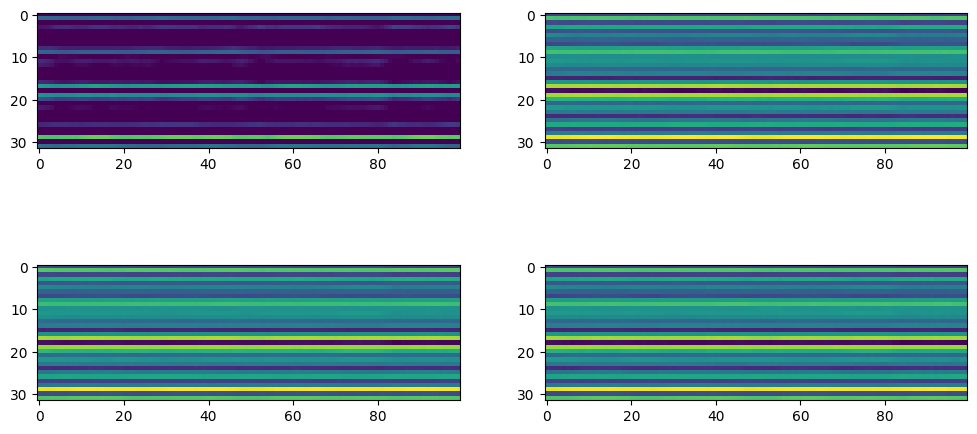

In [61]:
vmax = 1
ars = actor_net.num_aux_rewards
plt.figure(figsize=(12,6))
plt.subplot(2, 2, 1)
plt.imshow(aux_rs[:,0].detach().numpy().T, vmin=0, vmax=vmax)
plt.subplot(2, 2, 2)
plt.imshow(aux_vs[:,0,0*ars:1*ars].detach().numpy().T)
plt.subplot(2, 2, 3)
plt.imshow(aux_vs[:,0,1*ars:2*ars].detach().numpy().T)
plt.subplot(2, 2, 4)
plt.imshow(aux_vs[:,0,2*ars:3*ars].detach().numpy().T)

In [ ]:
actor_net.forward(obs, force_ae=True)
#actor_net.refresh_ae()

print("Actor network size: %d" % sum(p.numel() for p in actor_net.parameters()))

a = actor_net.ae.ae_inout.detach().numpy()
fig, axs = plt.subplots(2, 4, figsize=(12, 6))
# Loop over rows
for i in range(2):
    # Loop over columns
    for j in range(4):
        ax = axs[i][j]
        ax.axis('off')
        ax.imshow(a[i, j], cmap='gray')
plt.show()

In [ ]:
# emotion_ae branch

check_point_path = "/home/schk/log/v1g_0dis"
device = torch.device("cpu")

flags = util.parse(['--load_checkpoint', check_point_path])
env = Environment(flags=flags, model_wrap=False, env_n=1, device=device)
actor_net = ActorNet(obs_shape=None, gym_obs_shape=(12,96,96), num_actions=env.num_actions, flags=flags)
train_checkpoint = torch.load(os.path.join(check_point_path, "ckp_actor.tar"), torch.device("cpu"))
actor_net.set_weights(train_checkpoint["actor_net_state_dict"])
actor_net.train(False)

obs = env.initial()

aux_vs, aux_rs, encs, enc_ps, logits = [], [], [], [], []
for n in range(300):
    actor_out, core_state = actor_net(obs, force_ae=True)
    if actor_net.emotion_type == 1:
        aux_v = actor_out.baseline[0, :, 1:]
    aux_vs.append(actor_out.baseline[:, :, 1:])
    aux_rs.append(actor_out.aux_reward)
    encs.append(actor_net.ae.ae_hidden)
    enc_ps.append(actor_net.ae.ae_p)
    logits.append(actor_out.policy_logits)
    obs = env.step(actor_out.action.unsqueeze(-1))
    if n % 10 == 0: print(n)

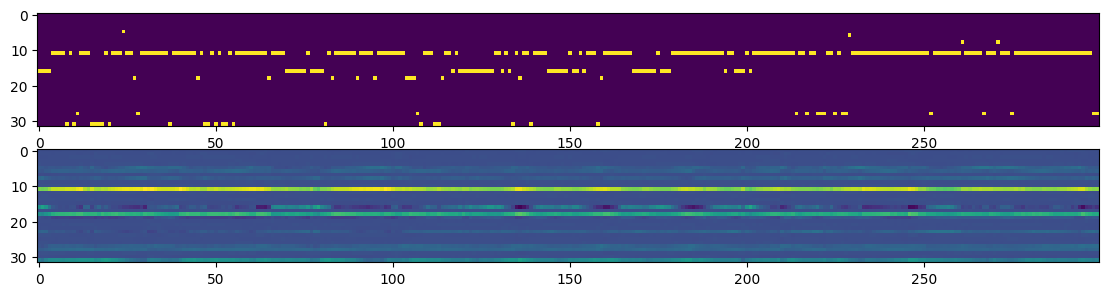

In [121]:
d = 12
x = torch.stack(aux_rs, dim=0)
plt.figure(figsize=(15,5))
plt.subplot(3, 1, 1)
plt.imshow(x[:,0,0,32*d:32*(d+1)].detach().numpy().T)

x = torch.stack(aux_vs, dim=0)
plt.subplot(3, 1, 2)
plt.imshow(x[:,0,0,32*d:32*(d+1)].detach().numpy().T)

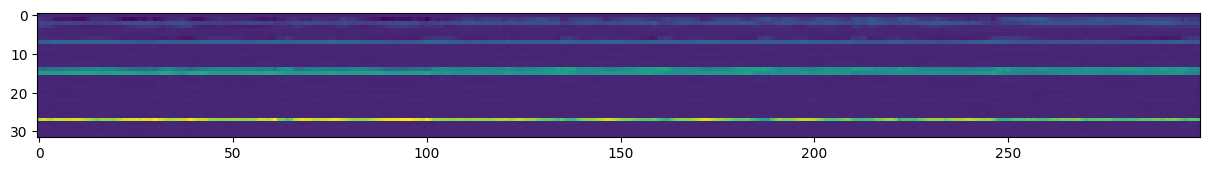

In [112]:
x = torch.stack(aux_vs, dim=0)
plt.figure(figsize=(15,5))
plt.imshow(x[:,0,0,:32].detach().numpy().T)

In [ ]:
x = torch.stack(enc_ps, dim=0)
plt.figure(figsize=(50,12))
plt.imshow(x[:,0,:32*5].detach().numpy().T)

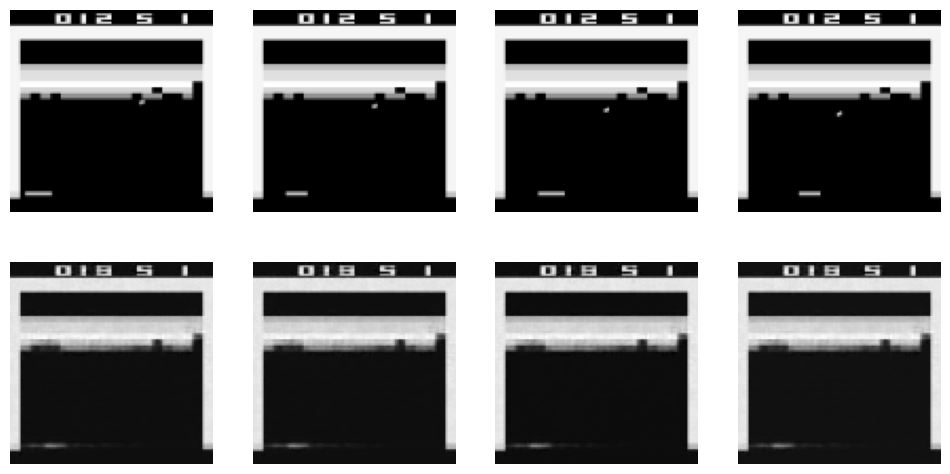

In [92]:
a = actor_net.ae.ae_inout.detach().numpy()
fig, axs = plt.subplots(2, 4, figsize=(12, 6))
# Loop over rows
for i in range(2):
    # Loop over columns
    for j in range(4):
        ax = axs[i][j]
        ax.axis('off')
        ax.imshow(a[i, j], cmap='gray')
plt.show()

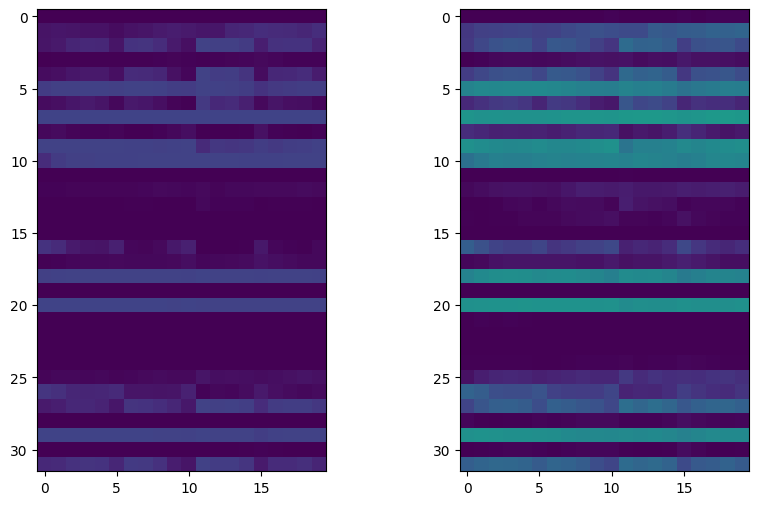

In [13]:
vmax = 5
x = torch.stack(aux_rs, dim=1)
ars = actor_net.aux_reward_size
plt.figure(figsize=(10,6))
plt.subplot(1, 2, 1)
plt.imshow(x[0][:20,:32].detach().numpy().T, vmin=0, vmax=vmax)
x = torch.stack(aux_vs, dim=1)
plt.subplot(1, 2, 2)
plt.imshow(x[0][:20,:32].detach().numpy().T, vmin=0, vmax=vmax)

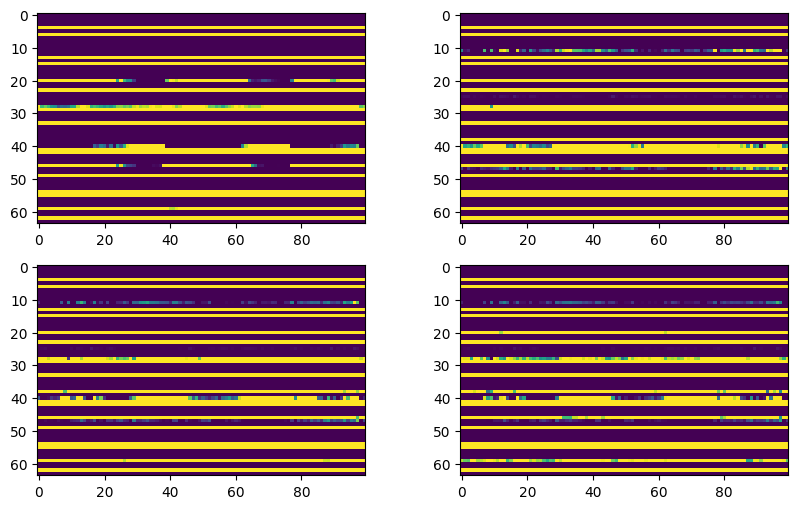

In [33]:
vmax = 1
x = torch.stack(aux_rs, dim=1)
ars = actor_net.aux_reward_size
plt.figure(figsize=(10,6))
plt.subplot(2, 2, 1)
plt.imshow(x[0].detach().numpy().T, vmin=0, vmax=vmax)
x = torch.stack(aux_vs, dim=1)
plt.subplot(2, 2, 2)
plt.imshow(x[0][:,0*ars:1*ars].detach().numpy().T, vmin=0, vmax=vmax)
plt.subplot(2, 2, 3)
plt.imshow(x[0][:,1*ars:2*ars].detach().numpy().T, vmin=0, vmax=vmax)
plt.subplot(2, 2, 4)
plt.imshow(x[0][:,2*ars:3*ars].detach().numpy().T, vmin=0, vmax=vmax)

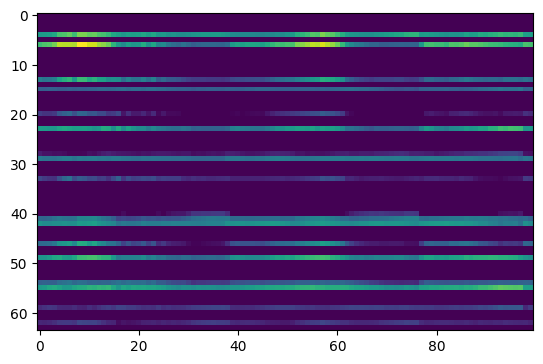

In [8]:
x = torch.stack(encs, dim=1)
plt.imshow(x[0].detach().numpy().T)
plt.show()

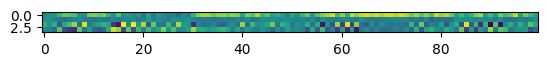

In [9]:
x = torch.stack(logits, dim=1)[0]
plt.imshow(x[:,0].detach().numpy().T)
plt.show()

In [35]:
x.shape

torch.Size([100, 8, 14])

In [112]:
check_point_path = "/mnt/d/data/emotion/logs/v1c_5e-6auxbase_preload"
flags = util.parse(['--load_checkpoint', check_point_path])
actor_net = ActorNet(obs_shape=None, gym_obs_shape=(12,96,96), num_actions=4, flags=flags)
train_checkpoint = torch.load(os.path.join(check_point_path, "ckp_actor.tar"), torch.device("cpu"))
actor_net.set_weights(train_checkpoint["actor_net_state_dict"])

model_enc = obs.gym_env_out.float() / 255.0
model_enc = torch.flatten(model_enc, 0, 1)
model_enc_1, aux_reward_1 = actor_net.actor_encoder(model_enc)
if actor_net.emotion_type == 1:
    model_enc_2, aux_reward_2 = actor_net.aux_reward_encoder(model_enc)
    aux_v = actor_net(obs)[0].baseline[:, :, 1:]
    aux_v = aux_v.reshape(aux_reward_1.shape)

print(aux_reward_1[0,4])    
if actor_net.emotion_type == 1:
    print(aux_reward_2[0,4])    
    print(aux_v[0,4])    


tensor([[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]], grad_fn=<SelectBackward0>)
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 3.3049, 1.6941, 1.1943, 0.7419, 0.0000],
        [0.0000, 0.6250, 0.0000, 0.5325, 0.0998, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 3.3836, 1.4138, 0.0000]])
tensor([[1.0526e+00, 5.1264e+00, 4.5980e+00, 3.1467e+00, 3.3541e+00, 6.8833e+00],
        [2.0960e+00, 3.4702e+00, 4.5762e+00, 2.8502e+00, 2.8050e+00, 5.1850e+00],
        [1.1540e+01, 6.6366e+01, 5.9732e+01, 2.9283e+01, 1.1531e+01, 2.0980e+01],
        [1.0588e+01, 2.9398e+01, 1.1946e+01, 1.1634e+01, 9.5560e+00, 2.2618e-02],
        [1.1272e+00, 1.3071e+00, 2.4242e+00, 5.3192e+00, 8.1734e+00, 5.7002e-01],
        [

In [105]:
print(aux_v[0][4])

tensor([[ 50.5148, -82.7892, -88.0143, -11.7322, 100.0000, -33.6090],
        [-90.2157, -90.0929, -90.0615, -89.9311, -89.9996, -90.2438],
        [-87.5698, -90.0060, -88.9507, -89.5715, -89.9547, -90.1669],
        [-78.6616, -81.3720, -78.7312, -80.6820, -71.0065, -73.1968],
        [-67.7155, -76.5985, -75.5794, -75.2023, -57.5426, -28.6207],
        [-68.5238, -53.8578, -72.0011, -68.2246, -27.4950, -21.0660]],
       grad_fn=<SelectBackward0>)


In [31]:
new_param = {k: v for k, v in actor_net.actor_encoder.state_dict().items() if k[:3] != "fc."}
new_param.update({k: v for k, v in actor_net.aux_reward_encoder.state_dict().items() if k[:3] == "fc."})
actor_net.aux_reward_encoder.load_state_dict(new_param)

<All keys matched successfully>

In [2]:
check_point_path = "/mnt/d/data/emotion/logs/v1b_0auxbase/ckp_actor.tar"
check_point = torch.load(check_point_path)
flags = check_point['flags']
actor_net = ActorNet(obs_shape=None, gym_obs_shape=(12,96,96), num_actions=4, flags=flags)